In [42]:
%matplotlib inline

import pandas as pd
import numpy as np
import datetime
import math
import colour
import matplotlib

from dash import Dash, html, dcc
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=False)

from typing import *

app = Dash(__name__)

PLOTLY_THEME = "plotly_white"
EXPORT_DIR = "image_out"
MAIN_DATA = "data.csv"

import os

if not os.path.exists(EXPORT_DIR):
    os.mkdir(EXPORT_DIR)

# Load Datasets

In [43]:
if not os.path.exists(MAIN_DATA):
    # Auto download from pre-computed Nextcloud server
    import requests
    r = requests.get("https://next.jmw.nz/s/L7drTr5wLqs67Te/download")
    with open(MAIN_DATA, "wb") as f:
        f.write(r.content)

In [44]:
power_sources = pd.read_csv("power_sources.csv", header=None)
power_sources.columns = ["source_id","source","ci-co2-per-kwh"]
power_sources

source_id      source  ci-co2-per-kwh
0          1     battery               8
1          2      co_gen             249
2          3         gas             410
3          4        coal            1073
4          5       hydro               8
5          6  geothermal              90
6          8        wind               7
7          7      diesel             850

In [45]:
data_raw = pd.read_csv(MAIN_DATA, index_col=0)

# Convert reading_timestamp to datetime
data_raw["reading_timestamp"] = pd.to_datetime(data_raw["reading_timestamp"])

data_raw.loc[data_raw["source_id"]==5].tail(16)

source_id  generation  capacity         reading_timestamp
id                                                               
112420          5        2778      5415 2023-08-08 12:00:00+00:00
112428          5        2503      5415 2023-08-08 14:00:00+00:00
112436          5        2484      5415 2023-08-08 14:30:00+00:00
112444          5        2470      5415 2023-08-08 15:00:00+00:00
112452          5        2484      5415 2023-08-08 15:30:00+00:00
112460          5        2516      5415 2023-08-08 16:00:00+00:00
112468          5        2572      5415 2023-08-08 16:30:00+00:00
112476          5        2769      5415 2023-08-08 17:00:00+00:00
112484          5        3072      5415 2023-08-08 17:30:00+00:00
112492          5        3595      5415 2023-08-08 18:00:00+00:00
112500          5        4019      5415 2023-08-08 18:30:00+00:00
112508          5        4453      5415 2023-08-08 19:00:00+00:00
112516          5        4670      5415 2023-08-08 19:30:00+00:00
112524          5        4666      5415 2023-08-08 20:00:00+00:00
112532          5        4554      5415 2023-08-08 20:30:00+00:00
51575           5        3554      5415 2023-01-19 05:00:00+00:00

In [46]:
data_raw = data_raw.merge(power_sources)
data_raw

source_id  generation  capacity         reading_timestamp   source   
0               1           0         1 2022-08-20 02:30:00+00:00  battery  \
1               1           0         1 2022-08-20 03:00:00+00:00  battery   
2               1           0         1 2022-08-20 03:30:00+00:00  battery   
3               1           0         1 2022-08-20 04:00:00+00:00  battery   
4               1           0         1 2022-08-20 04:30:00+00:00  battery   
...           ...         ...       ...                       ...      ...   
112371          8         138      1040 2023-08-08 19:00:00+00:00     wind   
112372          8         119      1040 2023-08-08 19:30:00+00:00     wind   
112373          8         113      1040 2023-08-08 20:00:00+00:00     wind   
112374          8         102      1040 2023-08-08 20:30:00+00:00     wind   
112375          8         102      1040 2023-01-19 05:00:00+00:00     wind   

        ci-co2-per-kwh  
0                    8  
1                    8  
2                    8  
3                    8  
4                    8  
...                ...  
112371               7  
112372               7  
112373               7  
112374               7  
112375               7  

[112376 rows x 6 columns]

In [47]:
# Flatten data structure, it now has 16 columns
# 	id	source_id	generation	capacity	reading_timestamp\
# Transform so each of the 8 source_id's are in their own column with their generation and capacity
# Group the source ID's by their reading timestamp
generation_logs = data_raw.pivot_table(index=["reading_timestamp"], columns="source", values=["generation","ci-co2-per-kwh"]).reset_index()
generation_logs

reading_timestamp ci-co2-per-kwh                            
source                                  battery co_gen  coal diesel  gas   
0      2022-08-20 02:00:00+00:00              8    249  1073    850  410  \
1      2022-08-20 02:30:00+00:00              8    249  1073    850  410   
2      2022-08-20 03:00:00+00:00              8    249  1073    850  410   
3      2022-08-20 03:30:00+00:00              8    249  1073    850  410   
4      2022-08-20 04:00:00+00:00              8    249  1073    850  410   
...                          ...            ...    ...   ...    ...  ...   
14042  2023-08-08 18:30:00+00:00              8    249  1073    850  410   
14043  2023-08-08 19:00:00+00:00              8    249  1073    850  410   
14044  2023-08-08 19:30:00+00:00              8    249  1073    850  410   
14045  2023-08-08 20:00:00+00:00              8    249  1073    850  410   
14046  2023-08-08 20:30:00+00:00              8    249  1073    850  410   

                             generation                                       
source geothermal hydro wind    battery co_gen coal diesel   gas geothermal   
0              90     8    7          0    109    0      0   201        923  \
1              90     8    7          0     99    0      0   202        924   
2              90     8    7          0     87    0      0   221        923   
3              90     8    7          0     86    0      0   221        924   
4              90     8    7          0    101    0      0   251        924   
...           ...   ...  ...        ...    ...  ...    ...   ...        ...   
14042          90     8    7          0     69   89      0   906        979   
14043          90     8    7          0     75   40      0  1054        981   
14044          90     8    7          0     78   89      0  1077        981   
14045          90     8    7          0     73  565      0   598        981   
14046          90     8    7          0     73  142      0   960        980   

                   
source hydro wind  
0       2783  616  
1       2829  567  
2       2899  531  
3       2926  537  
4       2942  536  
...      ...  ...  
14042   4019  128  
14043   4453  138  
14044   4670  119  
14045   4666  113  
14046   4554  102  

[14047 rows x 17 columns]

In [48]:
SOURCE_ORDER = ["battery", "diesel", "wind", "geothermal", "co_gen", "gas", "coal", "hydro"]

# Scan for issues in Dataset

In [49]:
# Check for partial rows
generation_logs[generation_logs.isnull().any(axis=1)]


Empty DataFrame
Columns: [(reading_timestamp, ), (ci-co2-per-kwh, battery), (ci-co2-per-kwh, co_gen), (ci-co2-per-kwh, coal), (ci-co2-per-kwh, diesel), (ci-co2-per-kwh, gas), (ci-co2-per-kwh, geothermal), (ci-co2-per-kwh, hydro), (ci-co2-per-kwh, wind), (generation, battery), (generation, co_gen), (generation, coal), (generation, diesel), (generation, gas), (generation, geothermal), (generation, hydro), (generation, wind)]
Index: []

In [50]:
# Look for gaps in timeseries data where the data-collector was offline
# 1. Find the difference between each timestamp



last_timestamp = generation_logs["reading_timestamp"].iloc[0]

delta_errors_basic = pd.DataFrame(columns=["delta_time","time_of_day"])

def timeToNumeric(time: datetime.time) -> float:
    return time.hour + time.minute / 60

for timestamp in generation_logs["reading_timestamp"]:
    delta_time = timestamp - last_timestamp
    # 2. If the difference is greater than 15 minutes, then there is a gap
    if delta_time > pd.Timedelta(minutes=30):
        delta_errors_basic.loc[len(delta_errors_basic)] = [delta_time, timeToNumeric(timestamp.time())]
    last_timestamp = timestamp
delta_errors_basic

delta_time  time_of_day
0   0 days 01:30:00         17.0
1   2 days 13:00:00         10.5
2   3 days 19:30:00          2.5
3   0 days 01:00:00         20.0
4   2 days 03:30:00         23.5
..              ...          ...
253 0 days 01:30:00         13.5
254 0 days 02:00:00         14.0
255 0 days 01:00:00          9.0
256 0 days 01:30:00         13.5
257 0 days 02:00:00         14.0

[258 rows x 2 columns]

In [51]:
for index,err in delta_errors_basic.iterrows():
    if err["delta_time"].total_seconds() / 60**2 <= 0:
        print(err,index)

In [52]:
time_day_freq = delta_errors_basic["time_of_day"].value_counts().sort_index().rename_axis('unique_values').reset_index(name='counts')

In [53]:
# Set the desired time interval
import datetime

# Create a new DataFrame with the desired time slots

time_slots = list(map(lambda x:x/2,range(0,48)))

# Create a DataFrame with the time slots
time_df = pd.DataFrame({'unique_values': time_slots})

# Merge the existing DataFrame with the time slots DataFrame
time_day_freq = pd.merge(time_df, time_day_freq, on='unique_values', how='left')
# time_day_freq = pd.concat([time_df.set_index('unique_values'), time_day_freq.set_index('unique_values')], axis=1, join='outer')


# # Fill NaN values with 0
time_day_freq['counts'] = time_day_freq['counts'].fillna(0)

time_day_freq['unique_values'] = time_day_freq.apply(lambda x: datetime.time(hour = math.floor(x['unique_values']), minute= int((x['unique_values']%1)*60)), axis=1)

In [54]:

fig = px.line(time_day_freq, y="counts", x="unique_values", title="Start times for gaps in data collection")
fig.show()

In [55]:
# fig = px.violin(errors,labels={
#     "value": "Delta between readings during outage",
#     "variable": "Source"
# }, points='all', title="Gaps in data collection", orientation="h")
# fig.show()

COLLECTION_GAP_HEALING_THRESHOLD = pd.Timedelta(hours=5)

timeHours = list(map(lambda x: x[1]["delta_time"].total_seconds() / 60**2,delta_errors_basic.iterrows()))

fig = go.Figure()
fig.add_trace(go.Violin(x=timeHours, name=""))
fig.add_vline(x=5, line_dash="dot",
              annotation_text="small-big gap healing threshold", 
              annotation_position="top right",)

fig.update_traces(orientation='h', side='positive', width=3, points='all', )
fig.update_layout(xaxis_dtick=COLLECTION_GAP_HEALING_THRESHOLD.seconds / 60**2)
# Limit x axis to 0, max
fig.update_xaxes(range=[0, max(timeHours)])


fig.update_layout(title="Gaps in data collection", xaxis_title="Hours between readings")

fig.show()


In [56]:
# Find Small gaps and heal them
generation_logs_insert = pd.DataFrame(columns=generation_logs.columns)

last_timestamp = generation_logs["reading_timestamp"].iloc[0]
for index,row in generation_logs.iterrows():
    current_timestamp = row[("reading_timestamp","")]
    time_delta = current_timestamp - last_timestamp
    if time_delta > pd.Timedelta(minutes=30) and time_delta < COLLECTION_GAP_HEALING_THRESHOLD:
        # Get the last row
        last_row = generation_logs.iloc[index-1]
        # Get missing timestamps with interval of 30 minutes
        missing_timestamps = pd.date_range(last_timestamp, current_timestamp, freq="30min")[1:-1]
        # Generate new rows with the missing timestamps
        for i in missing_timestamps:
            # Data will be interpolated later
            generation_logs_insert.loc[len(generation_logs_insert)] = {("reading_timestamp",""):i}

    last_timestamp = current_timestamp

# Now insert new logs into the main DataFrame
generation_logs = pd.concat([generation_logs, generation_logs_insert], ignore_index=True).sort_values(by=("reading_timestamp",""))

generation_logs_insert

reading_timestamp ci-co2-per-kwh                          
source                                  battery co_gen coal diesel gas   
0      2022-08-20 16:00:00+00:00            NaN    NaN  NaN    NaN NaN  \
1      2022-08-20 16:30:00+00:00            NaN    NaN  NaN    NaN NaN   
2      2022-10-19 19:30:00+00:00            NaN    NaN  NaN    NaN NaN   
3      2022-10-25 11:30:00+00:00            NaN    NaN  NaN    NaN NaN   
4      2022-10-29 11:30:00+00:00            NaN    NaN  NaN    NaN NaN   
..                           ...            ...    ...  ...    ...  ..   
703    2023-08-07 12:30:00+00:00            NaN    NaN  NaN    NaN NaN   
704    2023-08-07 13:00:00+00:00            NaN    NaN  NaN    NaN NaN   
705    2023-08-08 12:30:00+00:00            NaN    NaN  NaN    NaN NaN   
706    2023-08-08 13:00:00+00:00            NaN    NaN  NaN    NaN NaN   
707    2023-08-08 13:30:00+00:00            NaN    NaN  NaN    NaN NaN   

                             generation                                     
source geothermal hydro wind    battery co_gen coal diesel gas geothermal   
0             NaN   NaN  NaN        NaN    NaN  NaN    NaN NaN        NaN  \
1             NaN   NaN  NaN        NaN    NaN  NaN    NaN NaN        NaN   
2             NaN   NaN  NaN        NaN    NaN  NaN    NaN NaN        NaN   
3             NaN   NaN  NaN        NaN    NaN  NaN    NaN NaN        NaN   
4             NaN   NaN  NaN        NaN    NaN  NaN    NaN NaN        NaN   
..            ...   ...  ...        ...    ...  ...    ...  ..        ...   
703           NaN   NaN  NaN        NaN    NaN  NaN    NaN NaN        NaN   
704           NaN   NaN  NaN        NaN    NaN  NaN    NaN NaN        NaN   
705           NaN   NaN  NaN        NaN    NaN  NaN    NaN NaN        NaN   
706           NaN   NaN  NaN        NaN    NaN  NaN    NaN NaN        NaN   
707           NaN   NaN  NaN        NaN    NaN  NaN    NaN NaN        NaN   

                   
source hydro wind  
0        NaN  NaN  
1        NaN  NaN  
2        NaN  NaN  
3        NaN  NaN  
4        NaN  NaN  
..       ...  ...  
703      NaN  NaN  
704      NaN  NaN  
705      NaN  NaN  
706      NaN  NaN  
707      NaN  NaN  

[708 rows x 17 columns]

In [57]:
for area in ("generation","ci-co2-per-kwh"):
    generation_logs[area] = generation_logs[area].interpolate(method='linear', axis=0)
generation_logs.head(32).tail(10)

reading_timestamp ci-co2-per-kwh                                
source                                  battery co_gen    coal diesel    gas   
22     2022-08-20 13:00:00+00:00            8.0  249.0  1073.0  850.0  410.0  \
23     2022-08-20 13:30:00+00:00            8.0  249.0  1073.0  850.0  410.0   
24     2022-08-20 14:00:00+00:00            8.0  249.0  1073.0  850.0  410.0   
25     2022-08-20 14:30:00+00:00            8.0  249.0  1073.0  850.0  410.0   
26     2022-08-20 15:00:00+00:00            8.0  249.0  1073.0  850.0  410.0   
27     2022-08-20 15:30:00+00:00            8.0  249.0  1073.0  850.0  410.0   
14047  2022-08-20 16:00:00+00:00            8.0  249.0  1073.0  850.0  410.0   
14048  2022-08-20 16:30:00+00:00            8.0  249.0  1073.0  850.0  410.0   
28     2022-08-20 17:00:00+00:00            8.0  249.0  1073.0  850.0  410.0   
29     2022-08-20 17:30:00+00:00            8.0  249.0  1073.0  850.0  410.0   

                             generation                                       
source geothermal hydro wind    battery co_gen coal diesel  gas  geothermal   
22           90.0   8.0  7.0        0.0  119.0  0.0    0.0  0.0  933.000000  \
23           90.0   8.0  7.0        0.0  118.0  0.0    0.0  0.0  934.000000   
24           90.0   8.0  7.0        0.0  115.0  0.0    0.0  0.0  936.000000   
25           90.0   8.0  7.0        0.0  114.0  0.0    0.0  0.0  936.000000   
26           90.0   8.0  7.0        0.0  119.0  0.0    0.0  0.0  936.000000   
27           90.0   8.0  7.0        0.0  118.0  0.0    0.0  0.0  936.000000   
14047        90.0   8.0  7.0        0.0  118.0  0.0    0.0  0.0  936.666667   
14048        90.0   8.0  7.0        0.0  118.0  0.0    0.0  0.0  937.333333   
28           90.0   8.0  7.0        0.0  118.0  0.0    0.0  0.0  938.000000   
29           90.0   8.0  7.0        0.0  118.0  0.0    0.0  5.0  939.000000   

                            
source        hydro   wind  
22      2198.000000  379.0  
23      2127.000000  358.0  
24      2118.000000  300.0  
25      2083.000000  287.0  
26      2027.000000  308.0  
27      2032.000000  287.0  
14047   2054.666667  312.0  
14048   2077.333333  337.0  
28      2100.000000  362.0  
29      2137.000000  452.0

##

# Choose A Data Subset

In [58]:
SUBSET_LENGTH = 500
generation_subset = generation_logs.tail(SUBSET_LENGTH)
generation_subset
print(f"Chosen {SUBSET_LENGTH}/{len(generation_logs)} rows")

Chosen 500/14755 rows


In [59]:
SUBSET_LENGTH = 500
generation_subset = generation_logs.tail(SUBSET_LENGTH)
generation_subset
print(f"Chosen {SUBSET_LENGTH}/{len(generation_logs)} rows")

Chosen 500/14755 rows


In [60]:
generation_subset

reading_timestamp ci-co2-per-kwh                                
source                                  battery co_gen    coal diesel    gas   
13574  2023-07-29 11:00:00+00:00            8.0  249.0  1073.0  850.0  410.0  \
13575  2023-07-29 11:30:00+00:00            8.0  249.0  1073.0  850.0  410.0   
13576  2023-07-29 12:00:00+00:00            8.0  249.0  1073.0  850.0  410.0   
14728  2023-07-29 12:30:00+00:00            8.0  249.0  1073.0  850.0  410.0   
14729  2023-07-29 13:00:00+00:00            8.0  249.0  1073.0  850.0  410.0   
...                          ...            ...    ...     ...    ...    ...   
14042  2023-08-08 18:30:00+00:00            8.0  249.0  1073.0  850.0  410.0   
14043  2023-08-08 19:00:00+00:00            8.0  249.0  1073.0  850.0  410.0   
14044  2023-08-08 19:30:00+00:00            8.0  249.0  1073.0  850.0  410.0   
14045  2023-08-08 20:00:00+00:00            8.0  249.0  1073.0  850.0  410.0   
14046  2023-08-08 20:30:00+00:00            8.0  249.0  1073.0  850.0  410.0   

                             generation                             
source geothermal hydro wind    battery      co_gen   coal diesel   
13574        90.0   8.0  7.0        0.0  108.000000  470.0    0.0  \
13575        90.0   8.0  7.0        0.0  108.000000  471.0    0.0   
13576        90.0   8.0  7.0        0.0  108.000000  452.0    0.0   
14728        90.0   8.0  7.0        0.0  108.666667  402.0    0.0   
14729        90.0   8.0  7.0        0.0  109.333333  352.0    0.0   
...           ...   ...  ...        ...         ...    ...    ...   
14042        90.0   8.0  7.0        0.0   69.000000   89.0    0.0   
14043        90.0   8.0  7.0        0.0   75.000000   40.0    0.0   
14044        90.0   8.0  7.0        0.0   78.000000   89.0    0.0   
14045        90.0   8.0  7.0        0.0   73.000000  565.0    0.0   
14046        90.0   8.0  7.0        0.0   73.000000  142.0    0.0   

                                                     
source          gas  geothermal   hydro        wind  
13574    506.000000  982.000000  2943.0   75.000000  
13575    461.000000  982.000000  2779.0   71.000000  
13576    367.000000  981.000000  2653.0   60.000000  
14728    362.666667  980.333333  2555.0   60.666667  
14729    358.333333  979.666667  2457.0   61.333333  
...             ...         ...     ...         ...  
14042    906.000000  979.000000  4019.0  128.000000  
14043   1054.000000  981.000000  4453.0  138.000000  
14044   1077.000000  981.000000  4670.0  119.000000  
14045    598.000000  981.000000  4666.0  113.000000  
14046    960.000000  980.000000  4554.0  102.000000  

[500 rows x 17 columns]

In [61]:


fig = px.line(x=generation_subset["reading_timestamp"], y=generation_subset[("generation","hydro")], title="Hydro Generation", markers=True, range_y=[0, max(generation_subset["generation"]["hydro"])])
fig.show()
print(SOURCE_ORDER)
sourcesIndex = list(map(lambda x: ("generation",x), SOURCE_ORDER))
print(sourcesIndex)
fig = px.area(generation_subset["generation"],x=generation_subset["reading_timestamp"], y=SOURCE_ORDER, title="All Source Generation", markers=False,labels={
                     "value": "Power Output (MW)",
                     "reading_timestamp": "Reading Date",
                 },
)
fig.update_xaxes(minor=dict(ticks="outside", showgrid=True))
# fancyCo2Output.update_layout(margin=dict())
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.show()

['battery', 'diesel', 'wind', 'geothermal', 'co_gen', 'gas', 'coal', 'hydro']
[('generation', 'battery'), ('generation', 'diesel'), ('generation', 'wind'), ('generation', 'geothermal'), ('generation', 'co_gen'), ('generation', 'gas'), ('generation', 'coal'), ('generation', 'hydro')]


# Calculate carbon intensity
> Data from https://ecotricity.co.nz/the-truth-behind-new-zealand-s-electricity-emissions and https://www.researchgate.net/publication/235458666_Estimation_of_Carbon_Footprints_from_Diesel_Generator_Emissions


In [62]:
MW_TO_KW = 1000
GRAMS_TO_TONNE = 1/(1000000)
co2_generation = (generation_logs["ci-co2-per-kwh"] * GRAMS_TO_TONNE) * (MW_TO_KW * generation_logs["generation"])
co2_generation["reading_timestamp"] = generation_logs["reading_timestamp"]
co2_generation["cumulative_output"] = co2_generation[power_sources["source"]].sum(axis=1)
co2_generation

source  battery  co_gen     coal  diesel     gas  geothermal   hydro   wind   
0           0.0  27.141    0.000     0.0   82.41       83.07  22.264  4.312  \
1           0.0  24.651    0.000     0.0   82.82       83.16  22.632  3.969   
2           0.0  21.663    0.000     0.0   90.61       83.07  23.192  3.717   
3           0.0  21.414    0.000     0.0   90.61       83.16  23.408  3.759   
4           0.0  25.149    0.000     0.0  102.91       83.16  23.536  3.752   
...         ...     ...      ...     ...     ...         ...     ...    ...   
14042       0.0  17.181   95.497     0.0  371.46       88.11  32.152  0.896   
14043       0.0  18.675   42.920     0.0  432.14       88.29  35.624  0.966   
14044       0.0  19.422   95.497     0.0  441.57       88.29  37.360  0.833   
14045       0.0  18.177  606.245     0.0  245.18       88.29  37.328  0.791   
14046       0.0  18.177  152.366     0.0  393.60       88.20  36.432  0.714   

source         reading_timestamp  cumulative_output  
0      2022-08-20 02:00:00+00:00            219.197  
1      2022-08-20 02:30:00+00:00            217.232  
2      2022-08-20 03:00:00+00:00            222.252  
3      2022-08-20 03:30:00+00:00            222.351  
4      2022-08-20 04:00:00+00:00            238.507  
...                          ...                ...  
14042  2023-08-08 18:30:00+00:00            605.296  
14043  2023-08-08 19:00:00+00:00            618.615  
14044  2023-08-08 19:30:00+00:00            682.972  
14045  2023-08-08 20:00:00+00:00            996.011  
14046  2023-08-08 20:30:00+00:00            689.489  

[14755 rows x 10 columns]

In [63]:
co2_generation_subset = co2_generation.tail(SUBSET_LENGTH)
co2_generation_subset

source  battery  co_gen     coal  diesel         gas  geothermal   hydro   
13574       0.0  26.892  504.310     0.0  207.460000       88.38  23.544  \
13575       0.0  26.892  505.383     0.0  189.010000       88.38  22.232   
13576       0.0  26.892  484.996     0.0  150.470000       88.29  21.224   
14728       0.0  27.058  431.346     0.0  148.693333       88.23  20.440   
14729       0.0  27.224  377.696     0.0  146.916667       88.17  19.656   
...         ...     ...      ...     ...         ...         ...     ...   
14042       0.0  17.181   95.497     0.0  371.460000       88.11  32.152   
14043       0.0  18.675   42.920     0.0  432.140000       88.29  35.624   
14044       0.0  19.422   95.497     0.0  441.570000       88.29  37.360   
14045       0.0  18.177  606.245     0.0  245.180000       88.29  37.328   
14046       0.0  18.177  152.366     0.0  393.600000       88.20  36.432   

source      wind         reading_timestamp  cumulative_output  
13574   0.525000 2023-07-29 11:00:00+00:00            851.111  
13575   0.497000 2023-07-29 11:30:00+00:00            832.394  
13576   0.420000 2023-07-29 12:00:00+00:00            772.292  
14728   0.424667 2023-07-29 12:30:00+00:00            716.192  
14729   0.429333 2023-07-29 13:00:00+00:00            660.092  
...          ...                       ...                ...  
14042   0.896000 2023-08-08 18:30:00+00:00            605.296  
14043   0.966000 2023-08-08 19:00:00+00:00            618.615  
14044   0.833000 2023-08-08 19:30:00+00:00            682.972  
14045   0.791000 2023-08-08 20:00:00+00:00            996.011  
14046   0.714000 2023-08-08 20:30:00+00:00            689.489  

[500 rows x 10 columns]

In [64]:
figCo2Intensity = make_subplots(
    rows=2, cols=1,
    specs=[[{"type": "scatter"}],[{"type": "heatmap"}]],
    )

In [65]:
import json
json.dumps(list(power_sources["source"]))

'["battery", "co_gen", "gas", "coal", "hydro", "geothermal", "wind", "diesel"]'

In [66]:

fancyCo2Output = px.area(co2_generation_subset, x="reading_timestamp", y=SOURCE_ORDER, title="CO2e Output per Source", markers=False,labels={
                     "value": "CO2e Output (Tonne/hr)",
                     "reading_timestamp": "Reading Date",

                 },
)
fancyCo2Output.update_xaxes(minor=dict(ticks="outside", showgrid=True))
fancyCo2Output.show()

In [67]:
figCo2Intensity = px.density_heatmap(x=co2_generation_subset["reading_timestamp"], y=[1]*SUBSET_LENGTH, z=co2_generation_subset["cumulative_output"],nbinsx=500, nbinsy=1, height=300, title="Cumulative CO2e Output")
figCo2Intensity.update_xaxes(minor=dict(ticks="outside", showgrid=True))
figCo2Intensity.show()


# Calculate CO2 Intensity

In [68]:
cum_generation = generation_logs["generation"][power_sources["source"]].sum(axis=1) #MW
co2_intensity = pd.DataFrame()

MW_TO_KW = 1000
TONNE_TO_GRAMS = 1000000

co2_intensity["intensity"] = ((co2_generation["cumulative_output"]*TONNE_TO_GRAMS)/(cum_generation*MW_TO_KW)) # tonne/KWh
co2_intensity["reading_timestamp"] = generation_logs["reading_timestamp"]
co2_intensity["cumulative_output_tonne_per_hour"] = co2_generation["cumulative_output"]
co2_intensity

intensity         reading_timestamp  cumulative_output_tonne_per_hour
0       47.322323 2022-08-20 02:00:00+00:00                           219.197
1       47.009738 2022-08-20 02:30:00+00:00                           217.232
2       47.683330 2022-08-20 03:00:00+00:00                           222.252
3       47.369195 2022-08-20 03:30:00+00:00                           222.351
4       50.169752 2022-08-20 04:00:00+00:00                           238.507
...           ...                       ...                               ...
14042   97.786107 2023-08-08 18:30:00+00:00                           605.296
14043   91.769025 2023-08-08 19:00:00+00:00                           618.615
14044   97.372683 2023-08-08 19:30:00+00:00                           682.972
14045  142.368639 2023-08-08 20:00:00+00:00                           996.011
14046  101.231684 2023-08-08 20:30:00+00:00                           689.489

[14755 rows x 3 columns]

In [69]:
co2_intensity_subset = co2_intensity.tail(SUBSET_LENGTH)
co2_intensity_subset

intensity         reading_timestamp  cumulative_output_tonne_per_hour
13574  167.409717 2023-07-29 11:00:00+00:00                           851.111
13575  170.852627 2023-07-29 11:30:00+00:00                           832.394
13576  167.126596 2023-07-29 12:00:00+00:00                           772.292
14728  160.245823 2023-07-29 12:30:00+00:00                           716.192
14729  152.881649 2023-07-29 13:00:00+00:00                           660.092
...           ...                       ...                               ...
14042   97.786107 2023-08-08 18:30:00+00:00                           605.296
14043   91.769025 2023-08-08 19:00:00+00:00                           618.615
14044   97.372683 2023-08-08 19:30:00+00:00                           682.972
14045  142.368639 2023-08-08 20:00:00+00:00                           996.011
14046  101.231684 2023-08-08 20:30:00+00:00                           689.489

[500 rows x 3 columns]

In [70]:
figCo2Intensity = px.line(co2_intensity_subset, x='reading_timestamp', y="intensity", title='Co2e Intensity', labels={'reading_timestamp':'Date', 'intensity':'Co2e Intensity (Tonne/KWh)'})
figCo2Intensity.show()
# Co2e Intensity (Tonne/KWh)

### Fit Co2 Range to Frequency Analysis

In [71]:
len(co2_intensity)

14755

In [72]:
from scipy import stats
BIN_COUNT = round(len(co2_intensity)/100)
co2_readings_freq = co2_intensity["intensity"].value_counts(bins = BIN_COUNT, normalize=True).sort_index().rename_axis('unique_values').reset_index(name='counts')
co2_readings_freq["avg_value"] = co2_readings_freq["unique_values"].apply(lambda x: x.mid)
co2_readings_freq

unique_values    counts  avg_value
0       (20.31, 21.566]  0.000881    20.9380
1      (21.566, 22.658]  0.001830    22.1120
2      (22.658, 23.751]  0.002440    23.2045
3      (23.751, 24.844]  0.005083    24.2975
4      (24.844, 25.936]  0.004947    25.3900
..                  ...       ...        ...
143  (176.721, 177.814]  0.000068   177.2675
144  (177.814, 178.907]  0.000000   178.3605
145  (178.907, 179.999]  0.000000   179.4530
146  (179.999, 181.092]  0.000068   180.5455
147  (181.092, 182.185]  0.000136   181.6385

[148 rows x 3 columns]

In [73]:
figCo2Intensity = px.line(co2_readings_freq, x='avg_value', y="counts", title="CO2e Intensity Frequency", labels={"avg_value": "CO2e Intensity (gCO2e/kWh)", "counts": "Frequency"})
figCo2Intensity.show()


### Get Range of Co2 Intensity

In [74]:
QUANTILE_RANGE = 0.005
# CO2_INTENSITY_MAX = co2_intensity["intensity"].quantile(q=1-QUANTILE_RANGE)
# CO2_INTENSITY_MIN = co2_intensity["intensity"].quantile(q=QUANTILE_RANGE)
CO2_INTENSITY_MAX = co2_intensity["intensity"].max()
CO2_INTENSITY_MIN = co2_intensity["intensity"].min()

(CO2_INTENSITY_MIN, CO2_INTENSITY_MAX)


(20.473134611733435, 182.18457387716231)

In [75]:
figCo2Intensity = px.line(co2_readings_freq, x='avg_value', y="counts", title="CO2e Intensity Frequency", labels={"avg_value": "CO2e Intensity (gCO2e/kWh)", "counts": "Frequency"})

figCo2Intensity = figCo2Intensity.add_vline(x=CO2_INTENSITY_MIN, line_dash="dash", annotation_text="Min CO2 Intensity")
figCo2Intensity = figCo2Intensity.add_vline(x=CO2_INTENSITY_MAX, line_dash="dash", annotation_text="Max CO2 Intensity")

figCo2Intensity.show()

### Get Range of CO2 Output

In [76]:
# CO2_OUTPUT_MAX = co2_intensity["cumulative_output_tonne_per_hour"].quantile(q=1-QUANTILE_RANGE)
# CO2_OUTPUT_MIN = co2_intensity["cumulative_output_tonne_per_hour"].quantile(q=QUANTILE_RANGE)

CO2_OUTPUT_MAX = co2_intensity["cumulative_output_tonne_per_hour"].min()
CO2_OUTPUT_MIN = co2_intensity["cumulative_output_tonne_per_hour"].max()


(CO2_OUTPUT_MIN, CO2_OUTPUT_MAX)


(1182.4049999999997, 90.458999999999989)

In [77]:
figCo2Intensity = px.density_heatmap(x=co2_intensity_subset["reading_timestamp"], y=[1]*len(co2_intensity_subset), z=co2_intensity_subset["intensity"],nbinsx=500, nbinsy=1, height=300, title="CO2e Intensity Output")
figCo2Intensity.update_layout(coloraxis_showscale=False)
figCo2Intensity.show()

fig2Co2Output = px.density_heatmap(x=co2_intensity_subset["reading_timestamp"], y=[1]*len(co2_intensity_subset), z=co2_intensity_subset["cumulative_output_tonne_per_hour"],nbinsx=500, nbinsy=1, height=300, title="Cumulative CO2e Output")
fig2Co2Output.update_layout(coloraxis_showscale=False)
fig2Co2Output.show()

fancyCo2Output = px.area(co2_generation_subset, x="reading_timestamp", y=SOURCE_ORDER, title="CO2e Output per Source", markers=False,labels={
                     "value": "CO2e Output (Tonne/hr)",
                     "reading_timestamp": "Reading Date",
                 },
)
fancyCo2Output.update_xaxes(minor=dict(ticks="outside", showgrid=True))
# fancyCo2Output.update_layout(margin=dict())
fancyCo2Output.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fancyCo2Output.show()


# Created Colour Scales

[[ 0.768      -0.233       0.219     ]
 [ 0.768      -0.21115789  0.21110526]
 [ 0.768      -0.18931579  0.20321053]
 [ 0.768      -0.16747368  0.19531579]
 [ 0.768      -0.14523684  0.18821053]
 [ 0.768      -0.12142105  0.18426316]
 [ 0.768      -0.09760526  0.18031579]
 [ 0.768      -0.07378947  0.17636842]
 [ 0.768      -0.04997368  0.17242105]
 [ 0.768      -0.02615789  0.16847368]
 [ 0.768      -0.00234211  0.16452632]
 [ 0.768       0.02147368  0.16057895]
 [ 0.768       0.05034211  0.15663158]
 [ 0.768       0.08257895  0.15268421]
 [ 0.768       0.11481579  0.14873684]
 [ 0.768       0.14705263  0.14478947]
 [ 0.768       0.17928947  0.14084211]
 [ 0.768       0.21152632  0.13689474]
 [ 0.768       0.24376316  0.13294737]
 [ 0.768       0.276       0.129     ]]
*                                                                             *
*   [ Conversion Path ]                                                       *
*                                                          

/opt/mambaforge/envs/DirtyWatts/lib/python3.11/site-packages/colour/utilities/verbose.py:266: ColourUsageWarning:

The "Automatic Colour Conversion Graph" is a beta feature, be mindful of this when using it. Please report any unexpected behaviour and do not hesitate to ask any questions should they arise.
This warning can be disabled with the "colour.utilities.suppress_warnings" context manager as follows:
with colour.utilities.suppress_warnings(colour_usage_warnings=True): 
    convert(*args, **kwargs)



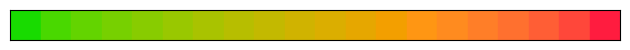

/opt/mambaforge/envs/DirtyWatts/lib/python3.11/site-packages/colour/utilities/verbose.py:266: ColourUsageWarning:

The "Automatic Colour Conversion Graph" is a beta feature, be mindful of this when using it. Please report any unexpected behaviour and do not hesitate to ask any questions should they arise.
This warning can be disabled with the "colour.utilities.suppress_warnings" context manager as follows:
with colour.utilities.suppress_warnings(colour_usage_warnings=True): 
    convert(*args, **kwargs)



*                                                                             *
*   [ Conversion Path ]                                                       *
*                                                                             *
*   "Oklab_to_XYZ" --> "XYZ_to_RGB"                                           *
*                                                                             *
what [[  8.99841480e-03   7.08361632e-01  -1.12459976e-01]
 [  6.61644943e-02   6.83679143e-01  -9.92230888e-02]
 [  1.24192019e-01   6.58696146e-01  -8.56400031e-02]
 [  1.83090102e-01   6.33408845e-01  -7.17049695e-02]
 [  2.45453395e-01   6.06996529e-01  -5.88650369e-02]
 [  3.19285183e-01   5.76969997e-01  -5.16735097e-02]
 [  3.94415663e-01   5.46569102e-01  -4.44512150e-02]
 [  4.70860591e-01   5.15788793e-01  -3.71978521e-02]
 [  5.48635723e-01   4.84624016e-01  -2.99131202e-02]
 [  6.27756811e-01   4.53069718e-01  -2.25967188e-02]
 [  7.08239613e-01   4.21120847e-01  -1.52483472e-02]
 

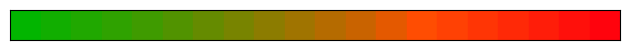

['rgb(24,219,0)',
 'rgb(73,216,0)',
 'rgb(99,212,0)',
 'rgb(119,208,0)',
 'rgb(136,204,0)',
 'rgb(153,200,0)',
 'rgb(169,195,0)',
 'rgb(183,190,0)',
 'rgb(195,185,0)',
 'rgb(208,179,0)',
 'rgb(219,174,0)',
 'rgb(230,167,0)',
 'rgb(243,159,0)',
 'rgb(255,150,19)',
 'rgb(255,139,31)',
 'rgb(255,126,40)',
 'rgb(255,112,47)',
 'rgb(255,94,53)',
 'rgb(255,71,58)',
 'rgb(255,28,63)']

In [78]:

GradientSetPointsX = np.array([0,0.2,0.6,1.0])
GradientSetPointsY = np.array([[0.768, -0.233, 0.219],[0.768, -0.15, 0.189],[0.768, 0.031, 0.159],[0.768, 0.276, 0.129]])

import scipy.interpolate
working_gradientL = scipy.interpolate.interp1d(GradientSetPointsX,GradientSetPointsY[:,0])(np.linspace(0, 1, 20))
working_gradientA = scipy.interpolate.interp1d(GradientSetPointsX,GradientSetPointsY[:,1])(np.linspace(0, 1, 20))
working_gradientB = scipy.interpolate.interp1d(GradientSetPointsX,GradientSetPointsY[:,2])(np.linspace(0, 1, 20))

gradientLab = np.array([working_gradientL,working_gradientA,working_gradientB]).T
# gradientLab = colour.algebra.lerp(
#     np.linspace(0, 1, 20)[..., np.newaxis],
#     OKLAB_ENDPOINTS[0][np.newaxis],
#     OKLAB_ENDPOINTS[1][np.newaxis],
#     )
print(gradientLab)

# RGB = colour.convert(CAM16UCS, 'CAM16UCS', 'Output-Referred RGB')
gradientRGBScreen = colour.convert(gradientLab, 'Oklab', 'Output-Referred RGB', verbose={'mode': 'short'})
print("what",gradientRGBScreen)
colour.plotting.plot_multi_colour_swatches(gradientRGBScreen)

gradientRGBLight = colour.convert(gradientLab, 'Oklab', 'RGB', verbose={'mode': 'short'})
print("what",gradientRGBLight)
colour.plotting.plot_multi_colour_swatches(gradientRGBLight)


# gradientHSV = colour.convert(gradientLab, 'Oklab', 'HSV')

PLOTLY_COLOURS = list(map(lambda x: f"rgb({','.join([str(round(min(max(i,0),1)*255)) for i in x[1]])})",enumerate(gradientRGBScreen)))
PLOTLY_COLOURS

In [79]:


figCo2Intensity = px.line(co2_readings_freq, x='avg_value', y="counts", title="CO2e Intensity Frequency", labels={"avg_value": "CO2e Intensity (gCO2e/kWh)", "counts": "Frequency"})

# figCo2Intensity = figCo2Intensity.add_vline(x=CO2_INTENSITY_MIN, line_dash="dash", annotation_text="Min CO2 Intensity")
# figCo2Intensity = figCo2Intensity.add_vline(x=CO2_INTENSITY_MAX, line_dash="dash", annotation_text="Max CO2 Intensity")

for i in GradientSetPointsX:
    colourSetpoint = PLOTLY_COLOURS[int(i*(len(PLOTLY_COLOURS)-1))]
    figCo2Intensity = figCo2Intensity.add_vline(x=(i*(CO2_INTENSITY_MAX-CO2_INTENSITY_MIN) + CO2_INTENSITY_MIN), line_dash="dash", annotation_text="CO2 Intensity Gradient Set Point",annotation_bgcolor=colourSetpoint, annotation_font_color="white")

figCo2Intensity.show()

In [80]:
# TOTAL GENERATION

fig = px.area(generation_subset["generation"],x=generation_subset["reading_timestamp"], y=SOURCE_ORDER, title="All Source Generation", markers=False,labels={
                     "value": "Power Output (MW)",
                     "reading_timestamp": "Reading Date",
                 },
)
fig.update_xaxes(minor=dict(ticks="outside", showgrid=True))
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.show()

# CO2 INTENSITY Color Bar

fig = go.Figure(go.Heatmap(
        x=co2_intensity_subset["reading_timestamp"],
        y=[1]*len(co2_intensity_subset),
        z=co2_intensity_subset["intensity"],
        colorscale=PLOTLY_COLOURS,
        zmin=CO2_INTENSITY_MIN,
        zmax=CO2_INTENSITY_MAX,
        showscale=False,
    ))
fig.update_layout(title="CO2e Intensity Output", height=250)
fig.show()

# CUMULATIVE CO2 OUTPUT

fig = px.area(co2_generation_subset, x="reading_timestamp", y=SOURCE_ORDER, title="CO2e Output per Source", markers=False,labels={
                     "value": "CO2e Output (Tonne/hr)",
                     "reading_timestamp": "Reading Date",
                 },
)
fig.update_xaxes(minor=dict(ticks="outside", showgrid=True))
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.show()
# cumulative_output_tonne_per_hour
# CUMULATIVE CO2 OUTPUT Color Bar
co2_generation["cumulative_output"]
fig = go.Figure(go.Heatmap(
        x=co2_generation_subset["reading_timestamp"],
        y=[1]*len(co2_generation_subset),
        z=co2_generation_subset["cumulative_output"],
        colorscale=PLOTLY_COLOURS,
        zmin=CO2_OUTPUT_MIN,
        zmax=CO2_OUTPUT_MAX,
        showscale=False,
    ))
fig.update_layout(title="Cumulative CO2e Output", height=250)
fig.show()
print(co2_generation_subset["cumulative_output"].min())





313.025


# Generate Colour Map DataPack

In [83]:
def createCPPTwoDArray(array):
    colourValues = list(map(lambda x : "{{{}}}".format(", ".join([str(round(min(max(i,0),1)*255)) for i in x])), array))
    body = ", ".join(colourValues)
    return '{{{}}}'.format(body)

gradientHexScreen = list(map(lambda x : matplotlib.colors.to_hex([min(max(i,0),1) for i in x]), gradientRGBScreen))
gradientRawScreen = list(map(lambda x : [round(min(max(i,0),1)*255) for i in x], gradientRGBScreen))
gradientCppScreen = createCPPTwoDArray(gradientRGBScreen)

gradientHexLight = list(map(lambda x : matplotlib.colors.to_hex([min(max(i,0),1) for i in x]), gradientRGBLight))
gradientRawLight = list(map(lambda x : [round(min(max(i,0),1)*255) for i in x], gradientRGBLight))
gradientCppLight = createCPPTwoDArray(gradientRGBLight)

print("Colour Map Screen:")
print(gradientHexScreen)
print(gradientRawScreen)
print(gradientCppScreen)

print("\nColour Map Light:")
print(gradientHexLight)
print(gradientRawLight)
print(gradientCppLight)


print(f"\nCo2e Intensity Range: [{round(CO2_INTENSITY_MIN)}, {round(CO2_INTENSITY_MAX)}]")
print(f"Co2e Output Range: [{round(CO2_OUTPUT_MIN)}, {round(CO2_OUTPUT_MAX)}]")

Colour Map Screen:
['#18db00', '#49d800', '#63d400', '#77d000', '#88cc00', '#99c800', '#a9c300', '#b7be00', '#c3b900', '#d0b300', '#dbae00', '#e6a700', '#f39f00', '#ff9613', '#ff8b1f', '#ff7e28', '#ff702f', '#ff5e35', '#ff473a', '#ff1c3f']
[[24, 219, 0], [73, 216, 0], [99, 212, 0], [119, 208, 0], [136, 204, 0], [153, 200, 0], [169, 195, 0], [183, 190, 0], [195, 185, 0], [208, 179, 0], [219, 174, 0], [230, 167, 0], [243, 159, 0], [255, 150, 19], [255, 139, 31], [255, 126, 40], [255, 112, 47], [255, 94, 53], [255, 71, 58], [255, 28, 63]]
{{24, 219, 0}, {73, 216, 0}, {99, 212, 0}, {119, 208, 0}, {136, 204, 0}, {153, 200, 0}, {169, 195, 0}, {183, 190, 0}, {195, 185, 0}, {208, 179, 0}, {219, 174, 0}, {230, 167, 0}, {243, 159, 0}, {255, 150, 19}, {255, 139, 31}, {255, 126, 40}, {255, 112, 47}, {255, 94, 53}, {255, 71, 58}, {255, 28, 63}}

Colour Map Light:
['#02b500', '#11ae00', '#20a800', '#2fa200', '#3f9b00', '#519300', '#658b00', '#788400', '#8c7c00', '#a07400', '#b56b00', '#c96300', '#e4